In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

file_path = ''
models_dir = 'models'

best_xgb_model = None
preprocessor = None
features_to_use = []
historical_weekly_avg = None
unique_stores_depts_list = []
df_stores_load = None
last_historical_date = None
df_final_for_context = None


In [2]:
try:
    best_xgb_model = joblib.load(os.path.join(models_dir, 'best_xgb_model.joblib'))
    preprocessor = joblib.load(os.path.join(models_dir, 'preprocessor.joblib'))

    df_stores_load = pd.read_csv(os.path.join(file_path, 'data/raw/stores data-set.csv'))
    df_features_load = pd.read_csv(os.path.join(file_path, 'data/raw/Features data set.csv'))
    df_sales_load = pd.read_csv(os.path.join(file_path, 'data/raw/sales data-set.csv'))

    # Replicar o pré-processamento para df_final_for_context
    df_sales_load['Date'] = pd.to_datetime(df_sales_load['Date'], format='%d/%m/%Y', errors='coerce')
    df_features_load['Date'] = pd.to_datetime(df_features_load['Date'], format='%d/%m/%Y', errors='coerce')
    df_sales_load.dropna(subset=['Date'], inplace=True)
    df_features_load.dropna(subset=['Date'], inplace=True)

    df_sales_stores_load = pd.merge(df_sales_load, df_stores_load, on='Store', how='left')
    df_final_for_context = pd.merge(df_sales_stores_load, df_features_load, on=['Store', 'Date'], how='left')

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df_final_for_context.columns:
            df_final_for_context[col] = df_final_for_context[col].fillna(0)

    economic_cols = ['CPI', 'Unemployment']
    for col in economic_cols:
        if col in df_final_for_context.columns:
            df_final_for_context[col] = df_final_for_context[col].interpolate(method='linear', limit_direction='both')
            if df_final_for_context[col].isnull().any():
                df_final_for_context[col] = df_final_for_context[col].fillna(df_final_for_context[col].mean())

    df_final_for_context = df_final_for_context[df_final_for_context['Weekly_Sales'] > 0]
    df_final_for_context['Date'] = pd.to_datetime(df_final_for_context['Date'], errors='coerce')
    df_final_for_context.dropna(subset=['Date'], inplace=True)

    df_final_for_context['Year'] = df_final_for_context['Date'].dt.year
    df_final_for_context['Month'] = df_final_for_context['Date'].dt.month
    df_final_for_context['Week'] = df_final_for_context['Date'].dt.isocalendar().week.astype(int)
    df_final_for_context['Day'] = df_final_for_context['Date'].dt.day
    df_final_for_context['DayOfWeek'] = df_final_for_context['Date'].dt.dayofweek
    df_final_for_context['DayOfYear'] = df_final_for_context['Date'].dt.dayofyear

    if 'IsHoliday_x' in df_final_for_context.columns and 'IsHoliday_y' in df_final_for_context.columns:
        df_final_for_context.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
        df_final_for_context.drop(columns=['IsHoliday_y'], inplace=True)
    elif 'IsHoliday_x' in df_final_for_context.columns:
        df_final_for_context.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
    elif 'IsHoliday_y' in df_final_for_context.columns:
        df_final_for_context.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

    if 'IsHoliday' in df_final_for_context.columns:
        df_final_for_context['IsHoliday_Flag'] = df_final_for_context['IsHoliday'].astype(int)

    df_final_for_context['SuperBowl'] = ((df_final_for_context['Month'] == 2) & (df_final_for_context['Week'].isin([6, 7])) | \
                                         (df_final_for_context['Month'] == 9) & (df_final_for_context['Week'].isin([36])) | \
                                         (df_final_for_context['Month'] == 11) & (df_final_for_context['Week'].isin([47])) | \
                                         (df_final_for_context['Month'] == 12) & (df_final_for_context['Week'].isin([51, 52]))).astype(int)
    df_final_for_context['IsHoliday'] = df_final_for_context['IsHoliday_Flag'].astype(bool)

    df_final_for_context['LaborDay'] = ((df_final_for_context['Month'] == 9) & (df_final_for_context['Week'].isin([36])) & (df_final_for_context['IsHoliday'] == True)).astype(int)
    df_final_for_context['Thanksgiving'] = ((df_final_for_context['Month'] == 11) & (df_final_for_context['Week'].isin([47])) & (df_final_for_context['IsHoliday'] == True)).astype(int)
    df_final_for_context['Christmas'] = ((df_final_for_context['Month'] == 12) & (df_final_for_context['Week'].isin([51, 52])) & (df_final_for_context['IsHoliday'] == True)).astype(int)

    # Note: Sample_Weight e TotalMarkDown/HasAnyMarkDown são criados no df_final_for_context para consistência
    df_final_for_context['Sample_Weight'] = 1.0
    df_final_for_context.loc[df_final_for_context['IsHoliday'] == True, 'Sample_Weight'] = 5.0

    existing_markdown_cols_in_context = [col for col in markdown_cols if col in df_final_for_context.columns]
    if existing_markdown_cols_in_context:
        df_final_for_context['TotalMarkDown'] = df_final_for_context[existing_markdown_cols_in_context].sum(axis=1)
        df_final_for_context['HasAnyMarkDown'] = (df_final_for_context['TotalMarkDown'] > 0).astype(int)
        for col in existing_markdown_cols_in_context:
            df_final_for_context[f'Has_{col}'] = (df_final_for_context[col] > 0).astype(int)

    features_to_use = [
        'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'IsHoliday_Flag',
        'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear',
        'SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas',
        'TotalMarkDown', 'HasAnyMarkDown'
    ]
    for col in existing_markdown_cols_in_context:
        if f'Has_{col}' not in features_to_use:
             features_to_use.append(f'Has_{col}')
        if col not in features_to_use:
            features_to_use.append(col)
    if 'Type' in df_stores_load.columns and 'Type' not in features_to_use: # df_stores_load contém a coluna Type
        features_to_use.append('Type')


    print("Modelos e contexto de dados carregados/reconstruídos para análise de promoções.")

except Exception as e:
    print(f"Erro na preparação dos dados ou carregamento de modelos: {e}")
    exit()

Modelos e contexto de dados carregados/reconstruídos para análise de promoções.



1. Importância das Features para o Modelo (Top 20):
         Feature  Importance
0   cat__Dept_92    0.103218
1   cat__Dept_95    0.086237
2   cat__Dept_90    0.044389
3   cat__Dept_38    0.040880
4   cat__Dept_72    0.037151
5   cat__Dept_40    0.032813
6   cat__Dept_28    0.026703
7    cat__Dept_2    0.026160
8   cat__Dept_13    0.025698
9   cat__Dept_27    0.020606
10   cat__Dept_8    0.020411
11  cat__Dept_60    0.020333
12  cat__Dept_19    0.019764
13  cat__Dept_91    0.018878
14  cat__Dept_93    0.018451
15  cat__Dept_37    0.017828
16  cat__Dept_94    0.017393
17  cat__Dept_54    0.017018
18  cat__Dept_35    0.016563
19  cat__Dept_50    0.013523


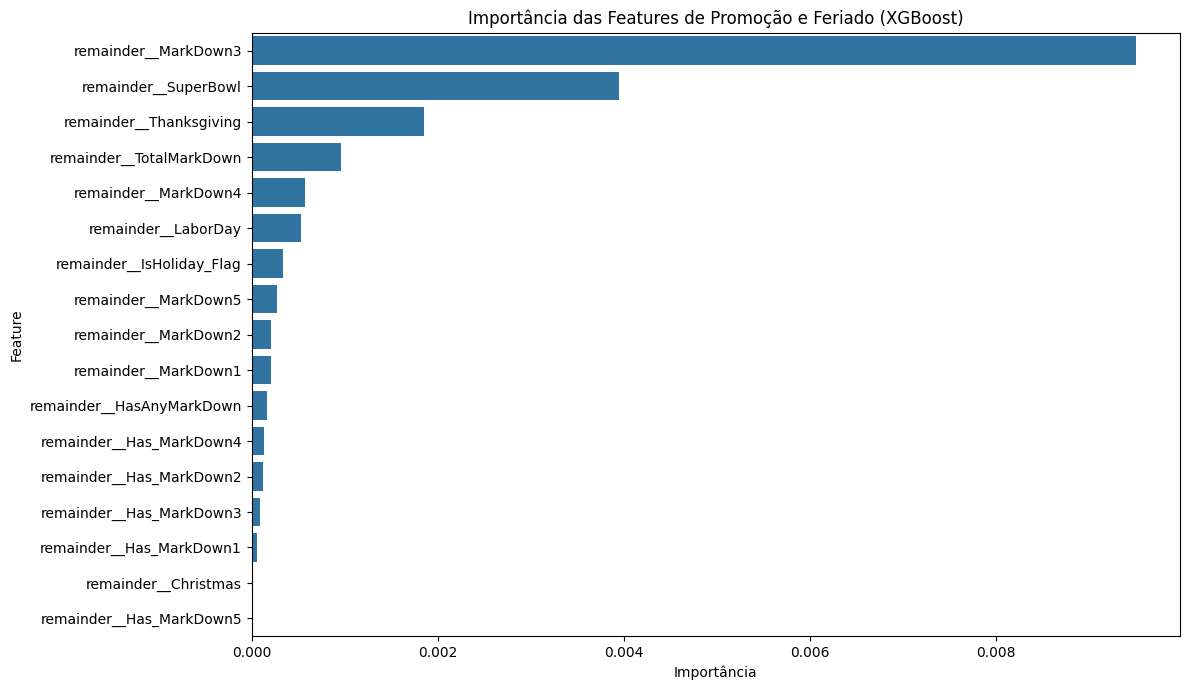

In [3]:
#Importância das Features de Promoção e Feriado
try:
    feature_importances = best_xgb_model.feature_importances_
    
    processed_feature_names = preprocessor.get_feature_names_out()

    importance_df = pd.DataFrame({'Feature': processed_feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\n1. Importância das Features para o Modelo (Top 20):")
    print(importance_df.head(20))

    promo_holiday_features_keywords = ['MarkDown', 'Holiday', 'SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas', 'Flag'] # Added 'Flag' for IsHoliday_Flag
    promo_holiday_importance = importance_df[
        importance_df['Feature'].str.contains('|'.join(promo_holiday_features_keywords), case=False, na=False)
    ].head(20)

    if not promo_holiday_importance.empty:
        plt.figure(figsize=(12, 7))
        sns.barplot(x='Importance', y='Feature', data=promo_holiday_importance)
        plt.title('Importância das Features de Promoção e Feriado (XGBoost)')
        plt.xlabel('Importância')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma feature de promoção/feriado encontrada entre as top 20 ou para plotar.")

except Exception as e:
    print(f"Erro ao analisar importância das features: {e}")
    print("Continuando com a análise histórica...")

In [4]:
#Impacto Histórico das Promoções
print("\n2. Análise do Impacto Histórico das Promoções e Feriados:")

sales_with_markdown = df_final_for_context[df_final_for_context['HasAnyMarkDown'] == 1]['Weekly_Sales'].mean()
sales_without_markdown = df_final_for_context[df_final_for_context['HasAnyMarkDown'] == 0]['Weekly_Sales'].mean()

print(f"\nMédia de Vendas Semanais com QUALQUER MarkDown: ${sales_with_markdown:,.2f}")
print(f"Média de Vendas Semanais SEM NENHUM MarkDown: ${sales_without_markdown:,.2f}")
print(f"Uplift (%) com MarkDowns: {((sales_with_markdown - sales_without_markdown) / sales_without_markdown * 100):.2f}%")

#Impacto de cada tipo de MarkDown (quando presente e > 0)
print("\nImpacto Médio de Cada Tipo de MarkDown (quando ativo):")
for md_col in existing_markdown_cols_in_context:
    if df_final_for_context[df_final_for_context[md_col] > 0]['Weekly_Sales'].count() > 10: #Pelo menos 10 ocorrências para significância
        avg_sales_when_md_active = df_final_for_context[df_final_for_context[md_col] > 0]['Weekly_Sales'].mean()
        print(f"  - Média de Vendas quando {md_col} > 0: ${avg_sales_when_md_active:,.2f}")


#Impacto das Semanas de Feriado
sales_holiday = df_final_for_context[df_final_for_context['IsHoliday'] == True]['Weekly_Sales'].mean()
sales_non_holiday = df_final_for_context[df_final_for_context['IsHoliday'] == False]['Weekly_Sales'].mean()

print(f"\nMédia de Vendas Semanais em Feriados: ${sales_holiday:,.2f}")
print(f"Média de Vendas Semanais em Não-Feriados: ${sales_non_holiday:,.2f}")
print(f"Uplift (%) em Feriados: {((sales_holiday - sales_non_holiday) / sales_non_holiday * 100):.2f}%")


#Impacto dos Feriados Específicos
print("\nImpacto Médio de Vendas em Feriados Específicos:")
specific_holidays = ['SuperBowl', 'LaborDay', 'Thanksgiving', 'Christmas']
for holiday_flag in specific_holidays:
    if holiday_flag in df_final_for_context.columns:
        sales_during_specific_holiday = df_final_for_context[df_final_for_context[holiday_flag] == 1]['Weekly_Sales'].mean()
        if not np.isnan(sales_during_specific_holiday):
            print(f"  - Média de Vendas durante {holiday_flag}: ${sales_during_specific_holiday:,.2f}")
        else:
            print(f"  - Dados insuficientes para {holiday_flag} para calcular a média de vendas.")



2. Análise do Impacto Histórico das Promoções e Feriados:

Média de Vendas Semanais com QUALQUER MarkDown: $16,231.12
Média de Vendas Semanais SEM NENHUM MarkDown: $15,922.14
Uplift (%) com MarkDowns: 1.94%

Impacto Médio de Cada Tipo de MarkDown (quando ativo):
  - Média de Vendas quando MarkDown1 > 0: $16,269.66
  - Média de Vendas quando MarkDown2 > 0: $17,105.31
  - Média de Vendas quando MarkDown3 > 0: $16,790.63
  - Média de Vendas quando MarkDown4 > 0: $17,083.40
  - Média de Vendas quando MarkDown5 > 0: $16,231.12

Média de Vendas Semanais em Feriados: $17,094.30
Média de Vendas Semanais em Não-Feriados: $15,952.82
Uplift (%) em Feriados: 7.16%

Impacto Médio de Vendas em Feriados Específicos:
  - Média de Vendas durante SuperBowl: $18,236.10
  - Média de Vendas durante LaborDay: $15,934.06
  - Média de Vendas durante Thanksgiving: $22,269.60
  - Média de Vendas durante Christmas: $14,635.14
